# Shaw 2023
This looks at high percentiles of upper troposphere (200hPa) zonal wind, to see how they vary with warming. Shaw 2023 indicated that the fastest winds increase the most.

In [2]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.convection import lapse_moist, equivalent_potential_temp
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, R, radius_earth, rot_earth, g
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.utils.calculus import grad_x, grad_y
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-01-22 12:33:40,001 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [3]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'ucomp', 'height', 'vcomp', 'ps']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
sigma_levels = np.asarray(namelist['vert_coordinate_nml']['bk'])         # make first value the surface
# Sigma levels are at half pressure levels, so need to convolve to get pressure at full pressure levels.
sigma_levels = np.convolve(sigma_levels, np.ones(2)/2, 'valid')

## Get datasets
Get one surface dataset for summer for each $\kappa$, combining all latitudes: `ds_all`.

In [4]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [117]:
# Load in dataset with surface and free troposphere across all latitudes, for given season
pressure_ft = 500           # Desired approximate pressure of free troposphere (hPa)
pressure_ft_ind = int(np.abs(ds[0].pfull-pressure_ft).argmin())
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
summer_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
season = 'all'
# season = 'summer'   # NOTE - if summer, does not give many days corresponding to high percentiles as only 5 years of data used

# Use zhang definition of extratropics
lat_min = 40
lat_max = 65
# lat_min = 80
# lat_max = 88

ds_all = []
ds_z_ft = []         # keep 'lon' and 'time' separate for z at ft level so can compute gradient
ds_sigma_correction = []        # need pressure levels either side of p_ft to compute gradient wrt pressure
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        # ds_use = ds[i].sel(pfull=[np.inf, pressure_ft], method='nearest').sel(time=slice(use_time_start, np.inf))
        # Keep all latitudes, so can do geostrophic wind calc without large gap between hemispheres
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))    
        ds_sigma_correction += [ds_use.isel(pfull=[pressure_ft_ind-1, pressure_ft_ind, pressure_ft_ind+1]
                                            ).stack(lon_time=("lon","time"), 
                                                    create_index=False).chunk(dict(lon_time=-1))[['vcomp', 'height', 'temp', 'ucomp']].load()]
        ds_use = ds_use.sel(pfull=[pressure_ft, np.inf], method='nearest')
        ds_z_ft += [ds_use.height.isel(pfull=0).transpose('lat', 'lon', 'time').load()]     # make time the last index
        
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)
        if season == 'summer':
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)
p_surface = float(ds_all[0].pfull[1]) * 100
pressure_ft_actual = float(ds_all[0].pfull[0]) * 100       # Actual pressure of free troposphere (Pa)
sigma_level_ft = sigma_levels[pressure_ft_ind]
# sigma_levels_use = sigma_levels[:len(ds_all[0].pfull)]      # Not all sigma levels are kept

n_lat = ds_all[0].lat.shape[0]
lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine
lat_keep_ind = np.where((np.abs(ds_z_ft[0].lat) <= lat_max) & (np.abs(ds_z_ft[0].lat) >= lat_min))[0]
# Only keep used latitudes for sigma correction
ds_sigma_correction = [ds_sigma_correction[i].isel(lat=lat_keep_ind) for i in range(n_exp)]

100%|██████████| 2/2 [00:54<00:00, 27.16s/it]


## Check Equation 7 of Zhang 2023
In the paper, it suggests we can approximate $z_{500} \approx \frac{\overline{z_{500}}}{\overline{T_{500}}}T_{500}$. Below I show that this seems reasonable for both $\kappa=1$ and the $\kappa=1.5$ simulations.

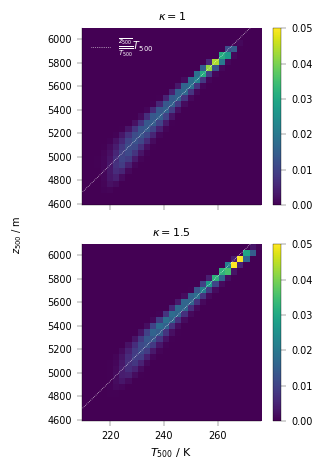

In [105]:
z_ft_mean = [float(area_weighting(ds_all[i].height[0]).mean()) for i in range(n_exp)]
temp_ft_mean = [float(area_weighting(ds_all[i].temp[0]).mean()) for i in range(n_exp)]

temp_bins = np.linspace(ds_all[0].temp[0].min(), ds_all[1].temp[0].max(), 30)
z_bins = np.linspace(ds_all[0].height[0].min(), ds_all[1].height[0].max(), 30)
z_hist = [np.histogram2d(ds_all[i].temp[0].to_numpy().flatten(), ds_all[i].height[0].to_numpy().flatten(), 
                         bins=[temp_bins, z_bins])[0] for i in range(n_exp)]
# Check that z_ft vs temp_ft relationship is approximately valid
temp_ft_array = np.arange(200, 300)

save_z_t_hist_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2 * width['one_col']/ar), sharex=True, sharey=True)
for i in range(n_exp):
    im = ax[i].imshow(z_hist[i].T/z_hist[i].sum(), origin='lower', aspect='auto', 
                      extent=[temp_bins[0], temp_bins[-1], z_bins[0], z_bins[-1]], vmin=0, vmax=0.05)
    ax[i].plot(temp_ft_array, (z_ft_mean[i]/temp_ft_mean[i] * temp_ft_array), color='w', linestyle=':',
            label='$\\frac{\overline{z_{500}}}{\overline{T_{500}}} T_{500}$')
    ax[i].set_title(f'$\kappa={tau_lw[i]}$')
    fig.colorbar(im)
fig.supylabel(f"$z_{'{'+str(pressure_ft)+'}'}$ / m", fontsize=7)
ax[-1].set_xlabel(f"$T_{'{'+str(pressure_ft)+'}'}$ / K")
ax[0].legend(labelcolor='w')
ax[0].set_xlim(temp_bins[0], temp_bins[-1])
ax[0].set_ylim(z_bins[0], z_bins[-1])
plt.tight_layout()

if save_fig or save_z_t_hist_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/z_t_hist.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

Below, I look at the difference between the simulations to see if $\delta z_{500} \approx \frac{\delta \overline{z_{500}}}{\delta \overline{T_{500}}}\delta T_{500}$.

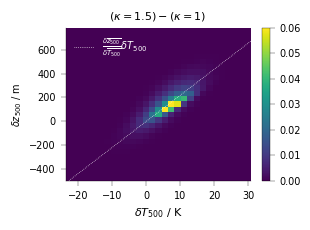

In [106]:
z_ft_diff_mean = float(area_weighting(ds_all[1].height[0]-ds_all[0].height[0]).mean())
temp_ft_diff_mean = float(area_weighting(ds_all[1].temp[0]-ds_all[0].temp[0]).mean())

temp_diff_bins = np.linspace((ds_all[1].temp[0] - ds_all[0].temp[0]).min(), (ds_all[1].temp[0] - ds_all[0].temp[0]).max(), 30)
z_diff_bins = np.linspace((ds_all[1].height[0] - ds_all[0].height[0]).min(), (ds_all[1].height[0] - ds_all[0].height[0]).max(), 30)

z_diff_hist = np.histogram2d((ds_all[1].temp[0] - ds_all[0].temp[0]).to_numpy().flatten(), 
                             (ds_all[1].height[0] - ds_all[0].height[0]).to_numpy().flatten(), bins=[temp_diff_bins, z_diff_bins])[0]
temp_ft_diff_array = np.arange(-50, 50)

save_z_t_diff_hist_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
im = ax.imshow(z_diff_hist.T/z_diff_hist.sum(), origin='lower', aspect='auto', 
               extent=[temp_diff_bins[0], temp_diff_bins[-1], z_diff_bins[0], z_diff_bins[-1]], vmin=0, vmax=0.06)
ax.plot(temp_ft_diff_array, (z_ft_diff_mean/temp_ft_diff_mean * temp_ft_diff_array), color='w', linestyle=':',
            label='$\\frac{\delta \overline{z_{500}}}{\delta \overline{T_{500}}} \delta T_{500}$')
ax.set_xlim(temp_diff_bins[0], temp_diff_bins[-1])
ax.set_ylim(z_diff_bins[0], z_diff_bins[-1])
ax.legend(labelcolor='w')
ax.set_ylabel(f"$\delta z_{'{'+str(pressure_ft)+'}'}$ / m", fontsize=7)
ax.set_xlabel(f"$\delta T_{'{'+str(pressure_ft)+'}'}$ / K")
ax.set_title(f'$(\kappa={tau_lw[1]}) - (\kappa={tau_lw[0]})$')
fig.colorbar(im)
plt.tight_layout()

if save_fig or save_z_t_diff_hist_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/z_t_diff_hist.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Check as function of percentile
Below I check the relationship between $\delta z_{500}(x)$ vs $\delta T_{500}(x)$ where $x$ is near-surface temperature percentile. The approximation seems to do a decent job at predicting the magnitude of $\delta z_{500}(x)$ but not the trend with $x$.

In [108]:
# Sanity check that way of reshaping ds_z_ft is consitent with lon_time coordinate
float(np.abs(ds_z_ft[0].isel(lat=lat_keep_ind).to_numpy().reshape(n_lat, -1) - ds_all[0].height[0]).max())

0.0

In [109]:
def get_geostrophic_wind(z_height, lat, lon, lat_axis=-2, lon_axis=-1):
    """
    Returns the geostrophic approximation for the zonal and meridional wind at 
    a given sigma level in the atmosphere.
    
    Args:
        z_height: [n_lat x n_lon x n_time]
            Geopotential height in m at a given sigma level.
        lat: [n_lat] in deg
        lon: [n_lon] in deg

    Returns:
        u_geo: [n_lat x n_lon x n_time]
        v_geo: [n_lat x n_lon x n_time]
    """
    z_shape = np.ones(len(z_height.shape), dtype=int)
    z_shape[lat_axis] = len(lat)
    f_coriolis = 2 * rot_earth * np.sin(np.deg2rad(lat).to_numpy()).reshape(z_shape)
    return -(g/f_coriolis) * grad_y(z_height, lat, lat_axis), (g/f_coriolis) * grad_x(z_height, lat, lon, lat_axis, lon_axis), 

In [112]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)

take_abs_v = True       # whether to consider speed or velocity of winds
if take_abs_v:
    v_func = lambda x: np.abs(x) 
else:
    v_func = lambda x: x
    
take_abs_u = True       # whether to consider speed or velocity of winds
if take_abs_u:
    u_func = lambda x: np.abs(x) 
else:
    u_func = lambda x: x

temp_mean = np.zeros((n_exp, 2, n_lat))         # second index: 0 is free trop, 1 is surface
z_mean = np.zeros((n_exp, n_lat))

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant3 = np.zeros((n_exp, 2, n_lat, n_quant))
# upper troposphere geopotential height as function of T percentile
z_quant3 = np.zeros((n_exp, n_lat, n_quant))
z_quant3_diff = np.zeros((n_exp, n_lat, n_quant))       # difference between quant3 and mean at that latitude.
# upper troposphere zonal wind as function of temperature percentile
# u_quant3 = np.zeros((n_exp, n_lat, n_quant))
# upper troposphere meridional wind as function of temperature percentile
v_quant3 = np.zeros((n_exp, n_lat, n_quant))
# FT geostrophic wind
v_geo_quant3 = np.zeros((n_exp, n_lat, n_quant))
# upper troposphere zonal wind as function of temperature percentile
u_quant3 = np.zeros((n_exp, n_lat, n_quant))
# FT geostrophic wind
u_geo_quant3 = np.zeros((n_exp, n_lat, n_quant))
# Surface pressure
p_surface_quant3 = np.zeros((n_exp, n_lat, n_quant))

with tqdm(total=n_exp*n_quant*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        temp_mean[i] = ds_all[i].temp.mean(dim='lon_time')       # surface temp at both pressure levels
        z_mean[i] = ds_all[i].height[0].mean(dim='lon_time')      
        u_geo_use, v_geo_use = get_geostrophic_wind(ds_z_ft[i], ds_z_ft[i].lat, ds_z_ft[i].lon, lat_axis=0, lon_axis=1)
        # Reshape so can take average on day corresponding to given quantile
        u_geo_use = u_geo_use[lat_keep_ind].reshape(n_lat, -1)
        v_geo_use = v_geo_use[lat_keep_ind].reshape(n_lat, -1)
        for k in range(n_lat):
            for j, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds_all[i].temp[1, k], quant, 0.5, 0.5)
                temp_quant3[i, :, k, j] = ds_all[i].temp[:, k, use_ind].mean(dim='lon_time', skipna=True)  
                z_quant3[i, k, j] = ds_all[i].height[0, k, use_ind].mean(skipna=True)      
                z_quant3_diff[i, k, j] = v_func(ds_all[i].height[0, k, use_ind]-z_mean[i,k]).mean(skipna=True)
                v_quant3[i, k, j] = v_func(ds_all[i].vcomp[0, k, use_ind]).mean(skipna=True)    
                v_geo_quant3[i, k, j] = v_func(v_geo_use[k, use_ind]).mean()
                u_quant3[i, k, j] = u_func(ds_all[i].ucomp[0, k, use_ind]).mean(skipna=True)    
                u_geo_quant3[i, k, j] = u_func(u_geo_use[k, use_ind]).mean()
                p_surface_quant3[i, k, j] = ds_all[i].ps[k, use_ind].mean(skipna=True)      
                pbar.update(1)

100%|██████████| 3564/3564 [00:32<00:00, 110.52it/s]


### Checking at pressure levels as well as sigma.
Isca outputs data at $\sigma = p/p_s$ levels. Here, I account for the variation of surface pressure, $p_s$, by obtaining the variables on a given pressure level.

To find a variable, $\Phi$, at pressure $p$ from the value at $\sigma$, I use:
$\Phi(p) = \Phi(\sigma) + (p - \sigma p_s)\frac{\partial \Phi}{\partial p}(\sigma)$

It doesn't appear to make much difference though.

In [118]:
# Obtain quantile data but at pressure_ft_actual, rather than at a sigma level

# quant2 is the actual quantile value rather than the average above a given quantile
temp_p_quant3 = np.zeros((n_exp, n_lat, n_quant))
# upper troposphere geopotential height as function of T percentile
z_p_quant3 = np.zeros((n_exp, n_lat, n_quant))
# upper troposphere zonal wind as function of temperature percentile
# u_quant3 = np.zeros((n_exp, n_lat, n_quant))
# upper troposphere meridional wind as function of temperature percentile
v_p_quant3 = np.zeros((n_exp, n_lat, n_quant))
u_p_quant3 = np.zeros((n_exp, n_lat, n_quant))

temp_p_mean = np.zeros((n_exp, n_lat)) 
z_p_mean = np.zeros((n_exp, n_lat))

with tqdm(total=n_exp*n_quant*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        p_diff = pressure_ft_actual - sigma_level_ft * ds_all[i].ps     # difference sigma level pressure and a given pressure
        temp_grad = p_diff * np.gradient(ds_sigma_correction[i].temp, ds_sigma_correction[i].pfull*100, axis=0)[1]
        z_grad = p_diff * np.gradient(ds_sigma_correction[i].height, ds_sigma_correction[i].pfull*100, axis=0)[1]
        v_grad = p_diff * np.gradient(ds_sigma_correction[i].vcomp, ds_sigma_correction[i].pfull*100, axis=0)[1]
        u_grad = p_diff * np.gradient(ds_sigma_correction[i].ucomp, ds_sigma_correction[i].pfull*100, axis=0)[1]
        
        temp_p_mean[i] = (ds_all[i].temp[0]+temp_grad).mean(dim='lon_time')       # surface temp at both pressure levels
        z_p_mean[i] = (ds_all[i].height[0]+z_grad).mean(dim='lon_time')      
        for k in range(n_lat):
            for j, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds_all[i].temp[1, k], quant, 0.5, 0.5)
                temp_p_quant3[i, k, j] = (ds_all[i].temp[0] + temp_grad)[k, use_ind].mean(dim='lon_time', skipna=True)  
                z_p_quant3[i, k, j] = (ds_all[i].height[0] + z_grad)[k, use_ind].mean(skipna=True)      
                v_p_quant3[i, k, j] = v_func((ds_all[i].vcomp[0] + v_grad)[k, use_ind]).mean(skipna=True)       
                u_p_quant3[i, k, j] = u_func((ds_all[i].ucomp[0] + u_grad)[k, use_ind]).mean(skipna=True)   
                pbar.update(1)

100%|██████████| 3564/3564 [01:24<00:00, 42.18it/s]


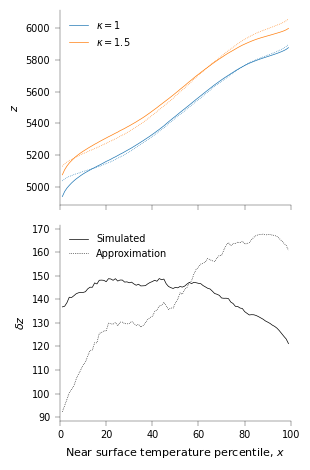

In [119]:
save_z_quant_fig = False
plot_include_p = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2 * width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(quant_plot, np.average(z_quant3[i], axis=0, weights=lat_weights), color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
    ax[0].plot(quant_plot, np.average(np.expand_dims(z_mean[i]/temp_mean[i, 0], axis=-1) * temp_quant3[i, 0], axis=0, weights=lat_weights), 
            color=default_colors[i], linestyle=':')
    if plot_include_p:
        ax[0].plot(quant_plot, np.average(z_p_quant3[i], axis=0, weights=lat_weights), color='green', alpha=0.4)
        ax[0].plot(quant_plot, np.average(np.expand_dims(z_p_mean[i]/temp_p_mean[i], axis=-1) * temp_p_quant3[i], axis=0, weights=lat_weights), 
                color='green', linestyle=':', alpha=0.4)
ax[1].plot(quant_plot, np.average(z_quant3[1]-z_quant3[0], axis=0, weights=lat_weights), color='k', label='Simulated')
ax[1].plot(quant_plot, np.average(np.expand_dims((z_mean[1]-z_mean[0])/(temp_mean[1, 0]-temp_mean[0, 0]), axis=-1) * 
                                  (temp_quant3[1, 0] - temp_quant3[0, 0]), axis=0, weights=lat_weights), 
           color='k', linestyle=':', label='Approximation')
if plot_include_p:
    ax[1].plot(quant_plot, np.average(z_p_quant3[1]-z_p_quant3[0], axis=0, weights=lat_weights), color='green', alpha=0.4)
    ax[1].plot(quant_plot, np.average(np.expand_dims((z_p_mean[1]-z_p_mean[0])/(temp_p_mean[1]-temp_p_mean[0]), axis=-1) * 
                                      (temp_p_quant3[1] - temp_p_quant3[0]), axis=0, weights=lat_weights), 
               color='green', linestyle=':', alpha=0.4)
ax[0].legend()
ax[1].legend()
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('$z$')
ax[1].set_ylabel('$\delta z$')
ax[1].set_xlabel('Near surface temperature percentile, $x$')
plt.tight_layout()

if save_fig or save_z_quant_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/z_quant.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

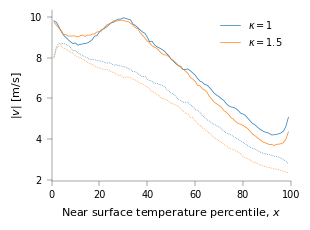

In [120]:
save_v_geo_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    ax.plot(quant_plot, np.average(v_quant3[i], axis=0, weights=lat_weights), color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
    ax.plot(quant_plot, np.average(v_geo_quant3[i], axis=0, weights=lat_weights), color=default_colors[i], linestyle=':')
    if plot_include_p:
        ax.plot(quant_plot, np.average(v_p_quant3[i], axis=0, weights=lat_weights), color=default_colors[i], alpha=0.4, linestyle='--')
ax.set_xlim(0, 100)
ax.legend()
ax.set_ylabel('$|v|$ [m/s]' if take_abs_v else '$v$ [m/s]')
ax.set_xlabel('Near surface temperature percentile, $x$')
plt.tight_layout()

if save_fig or save_v_geo_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/v_geo.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

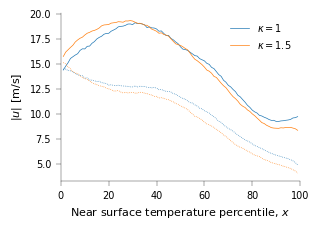

In [121]:
save_u_geo_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    ax.plot(quant_plot, np.average(u_quant3[i], axis=0, weights=lat_weights), color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
    ax.plot(quant_plot, np.average(u_geo_quant3[i], axis=0, weights=lat_weights), color=default_colors[i], linestyle=':')
    if plot_include_p:
        ax.plot(quant_plot, np.average(u_p_quant3[i], axis=0, weights=lat_weights), color=default_colors[i], alpha=0.4, linestyle='--')
ax.set_xlim(0, 100)
ax.legend()
ax.set_ylabel('$|u|$ [m/s]' if take_abs_u else '$u$ [m/s]')
ax.set_xlabel('Near surface temperature percentile, $x$')
plt.tight_layout()

if save_fig or save_u_geo_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/u_geo.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Consider a single time, to see if geostrophic approximation is valid

In [122]:
tau_ind_st = 0
time_ind_st = 1150
# time_ind_st = 1060
# pressure_ft_ind = int(np.abs(ds[0].pfull-300).argmin())
pressure_ft_ind_gradient_calc = [pressure_ft_ind-1, pressure_ft_ind, pressure_ft_ind+1]
ds_st = {}
ds_st['low'] = ds[tau_ind_st].isel(pfull=pressure_ft_ind_gradient_calc
                                   ).sel(time=time_ind_st, method='nearest')[['height', 'vcomp', 'ucomp', 'ps']].load()
ds_st['high'] = isca_tools.load_dataset('aquaplanet/high_res/').isel(pfull=pressure_ft_ind_gradient_calc
                                   ).sel(time=time_ind_st, method='nearest')[['height', 'vcomp', 'ucomp', 'ps']].load()
wind_sigma_adjustment = {}
for key in ds_st:
    wind_sigma_adjustment[key] = np.gradient(ds_st[key].height, sigma_levels[pressure_ft_ind_gradient_calc], axis=0)[1,:,:]
    ds_st[key] = ds_st[key].isel(pfull=1)       # only keep the one pressure level after computing gradient with sigma
    wind_sigma_adjustment[key] = wind_sigma_adjustment[key] * sigma_level_ft * grad_x(
        np.log(ds_st[key].ps), ds_st[key].lat, ds_st[key].lon, -2, -1)
wind_plot_spacing = {'low': 1, 'high': 2}

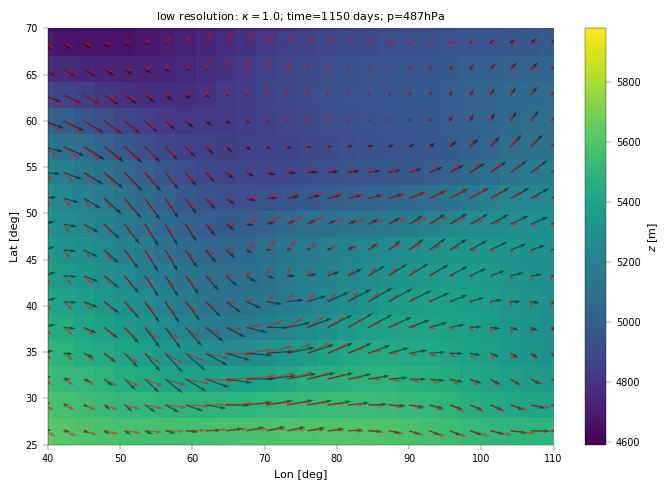

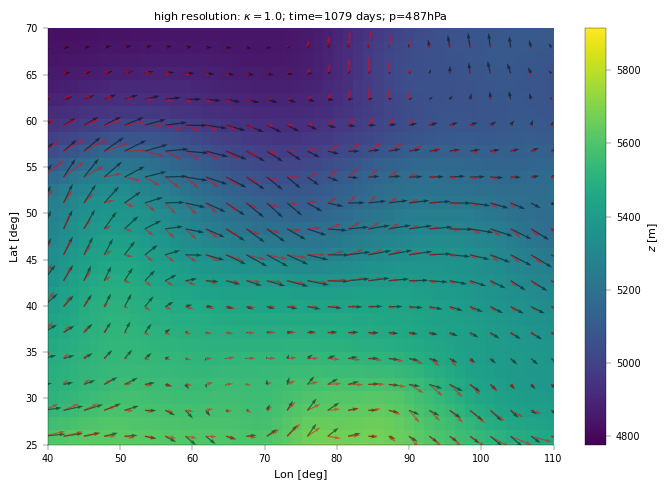

In [123]:
for key in ds_st:
    u_geo_st, v_geo_st = get_geostrophic_wind(ds_st[key].height, ds_st[key].lat, ds_st[key].lon)
    # v_geo_st2 = get_geostrophic_v(ds_st.height.to_numpy()[:, :, np.newaxis], ds_st.lon, ds_st.lat, 'forward').squeeze()
    # fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    fig, ax = plt.subplots(1,1, figsize=(7, 5))
    im = ax.pcolormesh(ds_st[key].lon, ds_st[key].lat, ds_st[key].height)
    pu, pv = (ds_st[key].ucomp[::wind_plot_spacing[key],::wind_plot_spacing[key]], 
              ds_st[key].vcomp[::wind_plot_spacing[key],::wind_plot_spacing[key]])
    ax.quiver(ds_st[key].lon[::wind_plot_spacing[key]], ds_st[key].lat[::wind_plot_spacing[key]], pu, pv, alpha=0.5, scale=800)
    pu, pv = u_geo_st[::wind_plot_spacing[key],::wind_plot_spacing[key]], v_geo_st[::wind_plot_spacing[key],::wind_plot_spacing[key]]
    ax.quiver(ds_st[key].lon[::wind_plot_spacing[key]], ds_st[key].lat[::wind_plot_spacing[key]], pu, pv, alpha=0.5, scale=800, color='r')
    plt.colorbar(im, ax=ax, label='$z$ [m]')
    ax.set_ylim(25, 70)
    ax.set_xlim(40, 110)
    # ax.set_ylim(10, 50)
    # ax.set_xlim(150, 250)
    ax.set_xlabel('Lon [deg]')
    ax.set_ylabel('Lat [deg]')
    ax.set_title("{} resolution: $\kappa={:.1f}$; time={:.0f} days; p={:.0f}hPa".format(key, tau_lw[tau_ind_st], 
                                                                                        ds_st[key].time-0.5, ds_st[key].pfull))
    plt.tight_layout()

### Is there a relationship between $z(x) - [\overline{z}]$ and $v(x)$?
If the wind where in geostrophic balance, then at a single latitude: $v(x) \propto \partial z / \partial x$. If we also have $\partial z / \partial x \propto z(x) - [\overline{z}]$, then we have $v(x) \propto z(x) - [\overline{z}]$, where the overline is an average over longitude, anmd the square brackets indicate an average over time.

Below, I consider a single latitude to test this.

In [179]:
tau_ind_scatter = 0
lat_ind_scatter = -4
ds_use = ds_all[tau_ind_scatter].isel(lat = lat_ind_scatter)
z_grad_x_use = grad_x(ds_z_ft[tau_ind_scatter], ds_z_ft[tau_ind_scatter].lat,
                      ds_z_ft[tau_ind_scatter].lon, lat_axis=0, lon_axis=1)[lat_keep_ind[lat_ind_scatter]].flatten()
z_diff_zonal_mean = (ds_z_ft[tau_ind_scatter][lat_keep_ind[lat_ind_scatter]] - ds_z_ft[tau_ind_scatter][lat_keep_ind[lat_ind_scatter]].mean(dim='lon')).to_numpy().flatten()

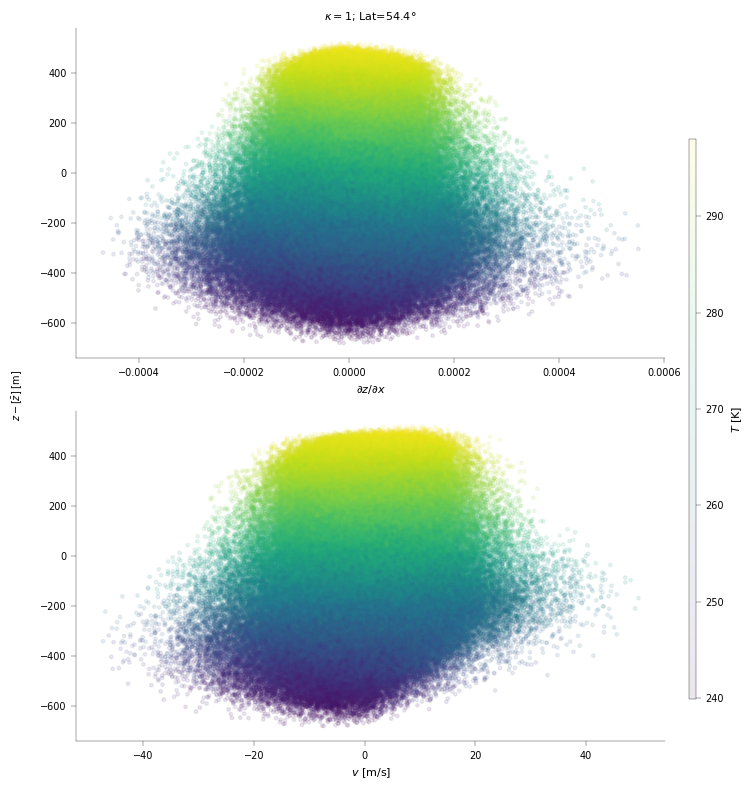

In [190]:
# fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
fig, ax = plt.subplots(2,1, figsize=(7, 8), sharey=True)
ax[0].scatter(z_grad_x_use, (ds_use.height[0] - ds_use.height[0].mean()).to_numpy().flatten(), c=ds_use.temp[1], alpha=0.1)
im = ax[1].scatter(ds_use.vcomp[0], (ds_use.height[0] - ds_use.height[0].mean()).to_numpy().flatten(), c=ds_use.temp[1], alpha=0.1)
ax[0].set_xlabel('$\partial z / \partial x$')
ax[1].set_xlabel('$v$ [m/s]')
fig.supylabel('$z - [\\bar{z}]$ [m]', fontsize=7)
ax[0].set_title(f'$\kappa = {tau_lw[tau_ind_scatter]}$; Lat={round(float(ds_use.lat),1)}$\degree$')
plt.tight_layout()
cbar_ax = fig.add_axes([0.99, 0.12, 0.01, 0.7])     # add axes for colorbar
fig.colorbar(im, cax=cbar_ax, label='$T$ [K]', aspect=100, pad=0.01, fraction=0.01);

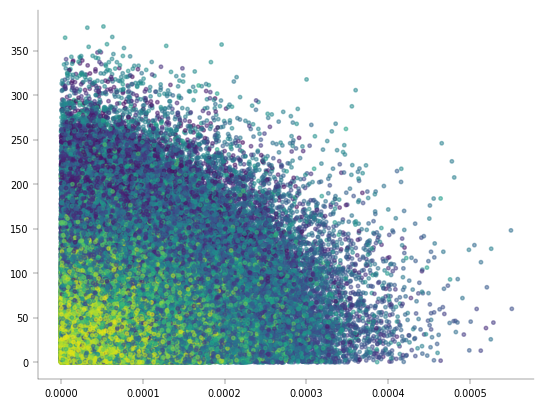

In [187]:
plt.scatter(np.abs(z_grad_x_use), np.abs(z_diff_zonal_mean), c=ds_use.temp[1], alpha=0.5)

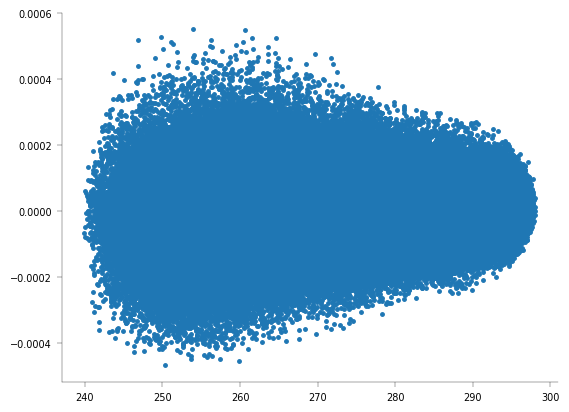

In [184]:
plt.scatter(ds_use.temp[1], z_grad_x_use)

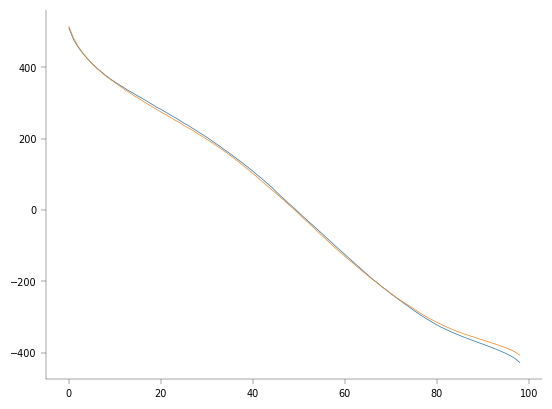

In [124]:
plt.plot(-np.average(z_quant3 - z_mean[:, :, np.newaxis], weights=lat_weights, axis=1)[0])
plt.plot(-np.average(z_quant3 - z_mean[:, :, np.newaxis], weights=lat_weights, axis=1)[1])

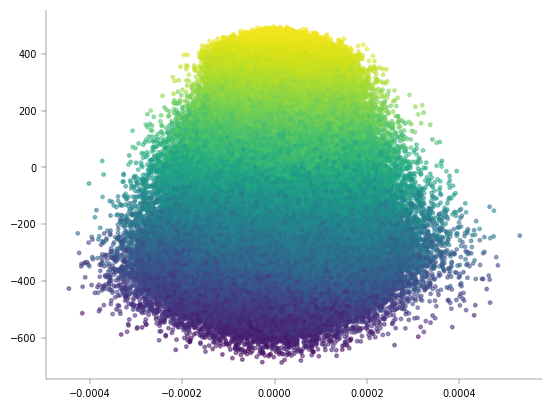

In [149]:
plt.scatter(grad_x(ds_z_ft[0], ds_z_ft[0].lat, ds_z_ft[0].lon, lat_axis=0, lon_axis=1)[lat_keep_ind[4]].flatten(), 
            (ds_z_ft[0][lat_keep_ind[4]] - ds_z_ft[0][lat_keep_ind[4]].mean()).to_numpy().flatten(), c=ds_all[0].temp[1, 4], alpha=0.5)

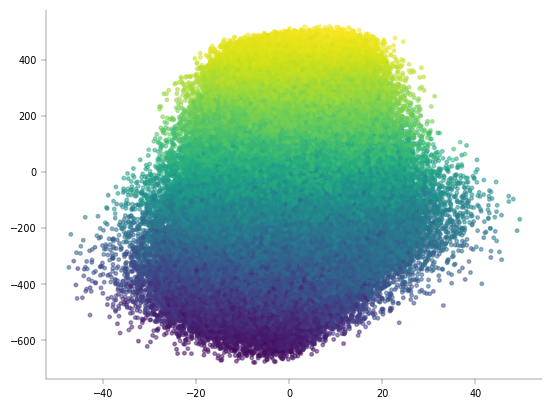

In [159]:
plt.scatter(ds_all[0].vcomp[0, -4], 
            (ds_z_ft[0][lat_keep_ind[-4]] - ds_z_ft[0][lat_keep_ind[-4]].mean()).to_numpy().flatten(), c=ds_all[0].temp[1, -4], alpha=0.5)

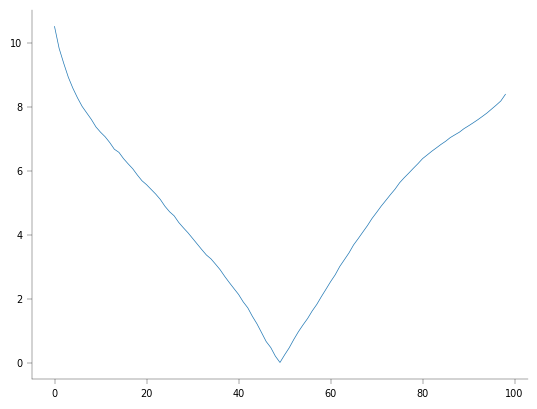

In [65]:
plt.plot(np.abs(z_quant3 - z_mean[:, :, np.newaxis])[0, 12]/50)

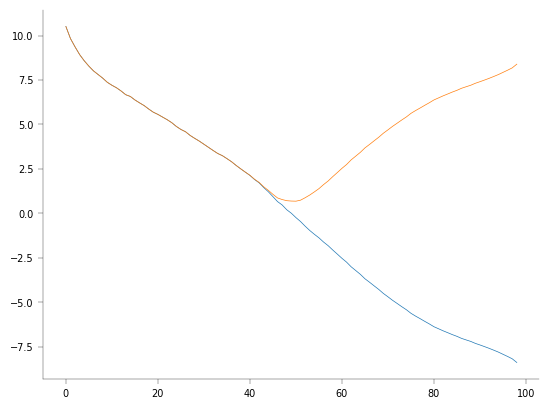

In [86]:
# plt.plot(v_geo_quant3[0, 12])
plt.plot(-(z_quant3 - z_mean[:, :, np.newaxis])[0, 12]/50)
plt.plot((z_quant3_diff)[0, 12]/50)
# plt.plot((z_quant3 - z_mean[:, :, np.newaxis])[0, 15])

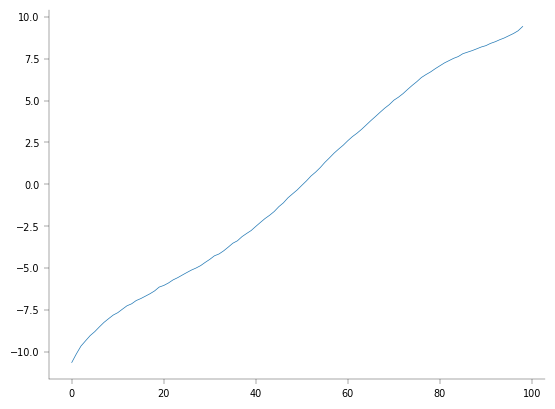

In [67]:
plt.plot((z_quant3 - z_mean[:, :, np.newaxis])[0, 15]/50)